In this notebook, we will be working through [Building makemore Part 2: Training Diagnostics](https://www.youtube.com/watch?v=P6sfmUTpUmc) by Andrej Karpathy. This is the fourth video in the "Neural Networks: Zero to Hero" series and covers part 2 of it.

In this video we will look at diagnostic tools that we can use to see if our models are training optimally.

**Why training diagnostics matter:** When a neural network underperforms, the loss number alone doesn't tell you _why_. Is the learning rate too high? Are gradients vanishing in deep layers? Are neurons saturating? Training diagnostics give us visibility into the internal dynamics of the network — activations, gradients, and parameter updates — so we can distinguish between a model that's learning healthily and one that's silently broken. This is especially important as networks get deeper, where problems like vanishing/exploding gradients can make training appear to work (the loss decreases) while the network is actually only learning in a subset of its layers.


# Section 1: "Pytorchify" Our Model

In the previous notebook, we had a very haphazard way of creating the model. Lets first package those into layers similar to how pytorch does it.

The idea here is to move from "raw tensor math" to **modular, composable layers** — each layer is a callable object that stores its own parameters and output. This is exactly the design pattern PyTorch uses with `torch.nn.Module`: each layer knows how to do its forward pass, what parameters it owns, and (via autograd) how to compute gradients. By adopting this pattern now, we accomplish two things:

1. **Cleaner code** — the forward pass becomes a simple loop through layers instead of a wall of matrix multiplications
2. **Diagnostic access** — each layer stores `self.out`, so after training we can inspect activations and gradients at every point in the network

Note that our custom classes below are simplified versions of PyTorch's `nn.Linear`, `nn.BatchNorm1d`, and `nn.Tanh`. They don't inherit from `nn.Module` (so no automatic parameter registration, `.to(device)`, `.eval()` mode toggling, etc.), but the core math is identical.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [22]:
# lets copy over some stuff from the previous notebook

# utility to read dataset
DATASET_PATH = '../names.txt'
SPECIAL_TOKEN = "."
device = 'cuda' if torch.cuda.is_available() else 'cpu'
g = torch.Generator(device=device).manual_seed(2147483647)

def get_dataset():
    with open(DATASET_PATH, 'r') as f:
        rows = [row.strip() for row in f.readlines()]
    return rows

# Load dataset
words = get_dataset()
print(f"{len(words)} names loaded")
print(f"Examples: {words[:8]}")

# Build character mappings — identical to lesson 2
# '.' is our special start/end token at index 0, then a=1, b=2, ..., z=26
all_characters = [SPECIAL_TOKEN] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(all_characters)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")
print(f"Mappings: {itos}")
print(f"Running on: {device}")

32033 names loaded
Examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Vocabulary size: 27
Mappings: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Running on: cuda


In [6]:
def build_dataset(words, block_size=3):
    """
    Convert a list of words into (X, Y) tensors for training.

    X shape: (N, block_size) — each row is a context window of character indices
    Y shape: (N,) — each element is the target character index

    This function will be called three times: once each for train, val, and test splits.
    """
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + SPECIAL_TOKEN:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

# 80/10/10 split at the word level
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=3)     # training
Xdev, Ydev = build_dataset(words[n1:n2], block_size=3)  # validation ("dev" set)
Xte, Yte = build_dataset(words[n2:], block_size=3)      # test

Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

print(f"Training:   {Xtr.shape[0]:>7,} examples from {n1:,} names")
print(f"Validation: {Xdev.shape[0]:>7,} examples from {n2-n1:,} names")
print(f"Test:       {Xte.shape[0]:>7,} examples from {len(words)-n2:,} names")

Training:   182,625 examples from 25,626 names
Validation:  22,655 examples from 3,203 names
Test:        22,866 examples from 3,204 names


### Reference: old-style model from the previous notebook

The cell below contains the raw-tensor implementation from the previous notebook (batch norm lesson). It's kept here commented-out as a reference point so we can compare the "before" and "after" as we refactor into modular layers. Notice how the forward pass is a single monolithic block of operations — by the end of this section, we'll replace that with a clean `for layer in layers` loop.


In [7]:
# Now this is the code we had at the end of the previous notebook

def get_params(embed_dim, block_size, n_hidden):

    tanh_gain = 5./3  # correction factor for tanh squashing variance

    g = torch.Generator().manual_seed(2147483647)
    C  = torch.randn((vocab_size, embed_dim),            generator=g)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g) * (tanh_gain / (embed_dim * block_size) ** 0.5)  # Kaiming with tanh gain
    b1 = torch.randn(n_hidden,                        generator=g) * 0.01  # small, near zero
    W2 = torch.randn((n_hidden, vocab_size),           generator=g) * (1 / (n_hidden) ** 0.5)  # Xavier (gain=1, no activation)
    b2 = torch.randn(vocab_size,                       generator=g) * 0.01  # small, near zero

    bngain = torch.ones((1, n_hidden))
    bnbias = torch.zeros((1, n_hidden))

    # add tracking variables which are NOT part of the training and thus dont receive gradients
    bnstd_running = torch.ones((1, n_hidden))
    bnmean_running = torch.zeros((1, n_hidden))

    parameters = [C, W1, b1, W2, b2, bngain, bnbias]
    for p in parameters:
        p.requires_grad = True

    return bnstd_running, bnmean_running, parameters

def train_model(params, n_steps=200000, batch_size=32):

    bnstd_running, bnmean_running, parameters = params
    C, W1, b1, W2, b2, bngain, bnbias = parameters

    stepi = []
    lossi = []
    loglossi = []

    pbar = tqdm(range(n_steps), desc="Training")
    for i in pbar:
        # Mini-batch: randomly sample 32 examples
        ixds = torch.randint(0, Xtr.shape[0], (batch_size,))
        mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

        # Forward pass
        emb = C[mini_batch_inp]                                        # (32, 3, 10)
        emb_cat = emb.view(emb.shape[0], -1)                            # (32, 30)
        hidden_layer_preactivation = emb_cat @ W1 + b1                  # (32, 200)

        # CONVERT hidden_layer_preactivation to unit gaussian
        _mean = hidden_layer_preactivation.mean(axis=0, keepdim=True) # (1, 200) take mean across the samples in the mini batch
        _std = hidden_layer_preactivation.std(axis=0, keepdim=True) # (1, 200) take std across the samples in the mini batch

        hidden_layer_preactivation = (hidden_layer_preactivation - _mean) / _std # convert to unit gaussian

        # move the running average slightly based on the currnet mean and std directions
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * _mean
            bnstd_running = 0.999 * bnstd_running + 0.001 * _std

        # scale and shift
        hidden_layer_preactivation = hidden_layer_preactivation*bngain + bnbias

        h = torch.tanh(hidden_layer_preactivation)  # (32, 200)
        logits = h @ W2 + b2                                           # (32, 27)
        loss = F.cross_entropy(logits, mini_batch_target)

        # Backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Learning rate step decay: 0.1 for first 100K steps, then 0.01
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        # Track loss
        stepi.append(i)
        lossi.append(loss.item())
        loglossi.append(loss.log10().item())

        if i % 10 == 0:
            pbar.set_postfix(loss=f"{loss.data:.4f}")

    return stepi, lossi, loglossi, hidden_layer_preactivation, h, logits, bnmean_running, bnstd_running

# now we can use these running mean and std during eval
@torch.no_grad()
def eval_loss(X, Y, params, embed_dim, block_size):

    bnstd_running, bnmean_running, parameters = params
    C, W1, b1, W2, b2, bngain, bnbias = parameters

    emb = C[X]
    emb_cat = emb.view(emb.shape[0], -1)

    hidden_layer_preactivation = emb_cat @ W1 + b1
    hidden_layer_preactivation = (hidden_layer_preactivation - bnmean_running) / bnstd_running
    hidden_layer_preactivation = hidden_layer_preactivation*bngain + bnbias

    h = torch.tanh(hidden_layer_preactivation)  # (32, 200)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

# bnstd_running, bnmean_running, parameters = get_params(embed_dim, block_size, n_hidden)

# stepi, lossi, loglossi, hidden_layer_preactivation, h, logits, bnmean_running, bnstd_running = \
#     train_model([bnstd_running, bnmean_running, parameters])

# print(f"Final Training loss: {eval_loss(Xtr, Ytr,[bnstd_running, bnmean_running, parameters], embed_dim, block_size)}, \
#     Validation Loss: {eval_loss(Xdev, Ydev, [bnstd_running, bnmean_running, parameters], embed_dim, block_size)}")

### `Linear` — our version of `torch.nn.Linear`

This layer computes `y = x @ W + b`. The key design choices:

- **Kaiming initialization** — we divide the random weights by `√fan_in` (the number of input features). This keeps the variance of the output roughly equal to the variance of the input, preventing activations from exploding or vanishing as data flows through the network. This is the same initialization PyTorch uses by default for `nn.Linear`.
- **`self.out`** — we store the output on the layer object so we can inspect it later for diagnostics. This is not something PyTorch does by default (you'd use forward hooks for that), but it's very convenient for learning.
- **No bias by default in some configurations** — when BatchNorm follows a Linear layer, the bias is redundant because BatchNorm subtracts the mean anyway (and then adds its own learnable bias `β`). That's why `setup_model` can pass `bias=False`.


In [56]:
# Create Linear Layer

class Linear:

    def __init__(self, num_input_features, num_output_features, bias=True, device='cpu'):

        initialization_factor = num_input_features ** 0.5 # kaiming he initialization

        self.weights = \
            torch.randn((num_input_features, num_output_features), generator=g, device=device) / initialization_factor
        self.bias = torch.zeros(num_output_features, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights # note that we keep the output under self so that we can access it later for diagnostics
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights, self.bias] if self.bias is not None else [self.weights]

    def __repr__(self):
        return f"Linear {tuple(list(self.weights.shape))})"

### `BatchNorm1d` — our version of `torch.nn.BatchNorm1d`

Batch normalization, introduced in [Ioffe & Szegedy 2015](https://arxiv.org/abs/1502.03167), normalizes each feature across the mini-batch to have zero mean and unit variance, then applies a learnable scale (`γ`) and shift (`β`). Key things to note:

- **Training vs. inference behavior** — during training, we compute mean/variance from the current mini-batch. During inference, we use the exponential moving averages (EMAs) accumulated during training. This dual behavior is why there's a `self.training` flag — and why in PyTorch you must call `model.eval()` before inference.
- **Why EMA and not just a simple average?** — We could average all training-set statistics at the end, but EMA is computed on-the-fly and adapts as the model's parameters change during training. The EMA with momentum 0.1 means each update blends 10% of the current batch stats with 90% of the running estimate.
- **`eps`** — a small constant (1e-5) added inside the square root to prevent division by zero when variance is near zero.
- **Why BatchNorm helps** — it reduces "internal covariate shift" (the original motivation), but more practically it acts as a form of regularization (each sample's normalization depends on what other samples are in the batch — a source of noise) and allows higher learning rates by keeping activations in a well-behaved range.


In [46]:
# Create batchnorm layer

class BatchNorm1d:

    def __init__(self, num_input_features, momentum=0.1, eps=1e-5, device='cpu'):

        self.eps = eps
        self.momentum = momentum

        # learnable scale and shift parameters (gain and bias)
        self.gamma = torch.ones(num_input_features, device=device)
        self.beta = torch.zeros(num_input_features, device=device)

        # Exponential moving average (EMA) tracking
        self.running_mean = torch.zeros(num_input_features, device=device)
        self.runnins_vars = torch.ones(num_input_features, device=device)

        self.training = True # batchnorm behaves different during training vs during inference/eval

    def __call__(self, x: torch.Tensor):

        if self.training:
            xmean = x.mean(axis=0, keepdim=True) # mean across batch
            xvars = x.var(axis=0, keepdim=True) # variance across batch
        else:
            xmean = self.running_mean
            xvars = self.runnins_vars

        # normalize
        self.out = (x - xmean) / torch.sqrt(xvars + self.eps)

        # scale and shift
        self.out = self.gamma * self.out + self.beta

        # EMA update

        if self.training:
            with torch.no_grad(): # these are not learnable params
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_vars = self.running_vars * (1 - self.momentum) + xvars * self.momentum

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

    def __repr__(self):
        return f"BatchNorm1d {tuple(list(self.gamma.shape))})"

### `Tanh` — activation function layer

Wrapping `torch.tanh` in a class might seem like overkill, but it serves the same purpose as the other layers: it stores `self.out` so we can inspect post-activation values during diagnostics. Later we'll use this to check for **saturation** — if too many tanh outputs are near ±1, gradients in those regions are near zero, and learning stalls (the "dead neuron" problem for tanh).


In [50]:
# Tanh

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

    def __repr__(self):
        return "Tanh ()"

### `setup_model` — composing layers into a network

This function builds the full network as a flat list of layers: `[Linear → BatchNorm → Tanh] × N → Linear`. This is equivalent to `torch.nn.Sequential` in PyTorch. A few important details:

- **`output_gain = 0.1`** — the output layer's weights are scaled down by 10×, so the initial logits are small and the softmax distribution starts nearly uniform. Without this, the model would start overconfident on random classes, producing a high initial loss and large gradients that can destabilize early training.
- **`tanh_gain = 5/3 ≈ 1.667`** — this compensates for tanh squashing the variance of its output. If input to tanh is standard normal, the output variance is less than 1 (because tanh compresses values toward ±1). The gain factor `5/3` is the empirically-derived correction from the [Kaiming He paper](https://arxiv.org/abs/1502.01852) that keeps the variance roughly stable through tanh layers. Note: this gain is applied _on top of_ the Kaiming `1/√fan_in` already in the `Linear` class.
- **Why separate `hidden_layers`?** — the gain adjustment only applies to Linear layers followed by tanh, _not_ to the output layer (which has no activation). Separating them lets us selectively apply the gain.


In [52]:
# make a fn to create a stack of layers

def setup_model(embed_dim,
                block_size,
                n_hidden_per_layer,
                num_hidden_layers = 4,
                bias = True,
                tanh = True,
                batchnorm = True,
                output_gain = 0.1,
                tanh_gain = 5./3,
                device = 'cpu'
                ):

    # create embedding lookup

    C = torch.randn((vocab_size, embed_dim), generator=g, device=device)

    flattened_input_features = embed_dim * block_size

    layers = []
    hidden_layers = []
    # setup input

    input_layer = Linear(flattened_input_features, n_hidden_per_layer, bias=bias, device=device)
    layers.append(input_layer)
    if batchnorm:
        x = BatchNorm1d(n_hidden_per_layer, device=device)
        layers.append(x)
    if tanh:
        x = Tanh()
        layers.append(x)

    # setup hidden
    for _ in range(num_hidden_layers):
        x = Linear(n_hidden_per_layer, n_hidden_per_layer, bias=bias, device=device)
        hidden_layers.append(x)
        if batchnorm:
            x = BatchNorm1d(n_hidden_per_layer, device=device)
            hidden_layers.append(x)
        if tanh:
            x = Tanh()
            hidden_layers.append(x)

    layers.extend(hidden_layers)

    # setup output layer
    output_layer = Linear(n_hidden_per_layer, vocab_size, bias=bias, device=device)
    layers.append(output_layer)

    # Now lets play with the gain a bit to see how it affects activations and gradients

    with torch.no_grad():

        # make last layer less confident for starting with uniform distribution
        output_layer.weights *= output_gain

        if tanh:
            for layer in hidden_layers: # if linear layers are followed by tanh, apply tanh gain
                if isinstance(layer, Linear):
                    layer.weights *= tanh_gain

    parameters = [C] + [param for layer in layers for param in layer.parameters()]
    print(f"Total number of parameters in model: {sum(p.nelement() for p in parameters)}")

    for p in parameters:
        p.requires_grad = True

    return C, layers, parameters

## Training loop with diagnostics

Lets also port over our training model code with a few changes -

1. **Retaining intermediate gradients** — By default, PyTorch only keeps gradients for "leaf" tensors (parameters you created directly). Intermediate results (like the output of a hidden layer) have their gradients discarded after `backward()` to save memory. Calling `retain_grad()` on `layer.out` tells PyTorch to keep those gradients so we can inspect them later. In production code, you'd use **forward/backward hooks** (`register_forward_hook`, `register_full_backward_hook`) instead, but `retain_grad()` is simpler for learning.

2. **Cleaner forward pass** — instead of manually writing out each matrix multiplication, we loop through our layer objects: `for layer in layers: x = layer(x)`. This is exactly what `nn.Sequential.__call__` does internally.

3. **Update-to-data ratio** — This is the key diagnostic Karpathy introduces. For each parameter tensor, we compute:

$$\text{ratio} = \frac{\text{std}(\text{lr} \times \nabla p)}{\text{std}(p)}$$

This tells us how large each gradient update is _relative to the parameter values themselves_. Karpathy's rule of thumb: this ratio should be roughly **1e-3** (i.e., the update is about 1/1000th the size of the parameter). If it's much larger, learning is unstable (parameters are being yanked around too aggressively). If it's much smaller, the parameters are barely changing and learning is too slow. This is a much more informative signal than just watching the loss curve.


In [63]:
def train_model(C, layers, parameters, n_steps = 200000, batch_size = 32, lr = 0.1, decayed_lr = 0.01):

    stepi = []
    lossi = []
    loglossi = []
    update_to_data_ratio = []

    pbar = tqdm(range(n_steps), desc="Training")
    for i in pbar:
        # Mini-batch: randomly sample 32 examples
        ixds = torch.randint(0, Xtr.shape[0], (batch_size,))
        mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

        # Forward pass
        emb = C[mini_batch_inp]
        x = emb.view(emb.shape[0], -1)

        for layer in layers:
            x = layer(x)

        # loss function
        loss = F.cross_entropy(x, mini_batch_target)

        # Backward pass

        # Retain gradients for intermediate layers for diagnostics
        for layer in layers:
            layer.out.retain_grad()

        for p in parameters:
            p.grad = None
        loss.backward()

        # Learning rate step decay: 0.1 for first 100K steps, then 0.01
        lr = lr if i < 100000 else decayed_lr
        for p in parameters:
            p.data += -lr * p.grad

        # Track loss
        stepi.append(i)
        lossi.append(loss.item())
        loglossi.append(loss.log10().item())

        if i % 10 == 0:
            pbar.set_postfix(loss=f"{loss.data:.4f}")

        with torch.no_grad():
            for p in parameters:

                update_std = lr * p.grad.std()
                data_std = p.data.std().log10().item()
                ratio = update_std / data_std
                update_to_data_ratio.append(ratio)

    return stepi, lossi, loglossi, update_to_data_ratio, layers, parameters


# Section 2: Creating Diagnostic Plots

Here we create a few diagnostic plots which will help with understanding how well a model is training.

These are the four core diagnostics Karpathy walks through in the video. Together, they give a complete picture of the network's health:

| Diagnostic                       | What it shows                                                | What to look for                                                                                             |
| -------------------------------- | ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------ |
| **Activation distribution**      | Values flowing _forward_ through each layer                  | Should be roughly Gaussian, centered near 0. If values pile up at ±1, tanh is saturating.                    |
| **Gradient distribution**        | Values flowing _backward_ through each layer                 | Should have similar scale across layers. If gradients shrink in earlier layers → vanishing gradient problem. |
| **Weight gradient distribution** | How much each weight matrix wants to change                  | Should be roughly the same order of magnitude across layers.                                                 |
| **Update-to-data ratio**         | Size of the actual parameter update vs. the parameter itself | Should hover around 1e-3. Much larger → unstable. Much smaller → learning too slowly.                        |


### Activation distribution

This plots a histogram of the output values at each Tanh layer. We're checking for **saturation**: when tanh outputs cluster near ±1 (above the 0.97 threshold), those neurons are in the flat region of tanh where the gradient is nearly zero. A saturated neuron can barely learn — it's effectively "dead" for that training step.

**Healthy activations** look like a smooth bell curve between -1 and +1 with most values well inside the ±0.97 range. **Unhealthy activations** show a bimodal distribution with peaks at ±1 (the "U-shape"), meaning the pre-activation values are too large and tanh is squashing everything to the extremes. This is exactly the kind of problem that proper weight initialization (Kaiming) and BatchNorm are designed to prevent.


In [81]:
def plot_activation_distribution(layers, layer_to_plot = Tanh):

    # visualize histograms
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, layer_to_plot):
            t = layer.out # this is the activation of the layer
            t = t.to(device="cpu")
            layer_name = layer.__class__.__name__
            saturation_count = (t.abs() > 0.97).float().mean()*100

            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer_name, t.mean(), t.std(), saturation_count))

            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer_name}')
    plt.legend(legends);
    plt.title('activation distribution')
    plt.show()


### Activation Gradient distribution

This is the backward-pass counterpart to the activation plot above. Instead of looking at `layer.out`, we look at `layer.out.grad` — the gradient of the loss with respect to each layer's output.

**What we're watching for:** the gradients should have roughly similar standard deviations across all layers. If the std shrinks dramatically in earlier layers (closer to the input), we have a **vanishing gradient problem** — those layers are receiving almost no learning signal. If it grows, we have **exploding gradients**.

In a well-initialized network with BatchNorm, the gradient magnitudes should be relatively uniform across layers, because BatchNorm helps stabilize both the forward and backward pass.


In [80]:
def plot_gradient_distribution(layers, layer_to_plot = Tanh):

    # visualize histograms
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, layer_to_plot):
            t = layer.out.grad # this is the gradient flowing through the layer
            t = t.to(device="cpu")
            layer_name = layer.__class__.__name__

            print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer_name, t.mean(), t.std()))

            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer_name}')
    plt.legend(legends);
    plt.title('activation distribution')
    plt.show()

### Weight gradient distribution

While the previous plot showed gradients flowing through activations, this one looks at the gradients on the **weight matrices themselves** — i.e., `p.grad` for each 2D parameter tensor. This tells us how much each weight matrix "wants" to change.

The key metric printed is the **grad:data ratio** (`grad.std() / param.std()`). If one layer's weights have gradients that are orders of magnitude smaller than other layers', that layer is learning much more slowly — a sign of poor initialization or vanishing gradients reaching that layer.

Note: we only plot 2D parameters (weight matrices), skipping 1D parameters (biases, BatchNorm gamma/beta) since the weight matrices contain the bulk of the model's capacity and are more informative for diagnostics.


In [78]:
def plot_weights_gradient_distribution(parameters):

    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i,p in enumerate(parameters):
        t = p.grad
        t = t.to(device="cpu")
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution')


### Update-to-data ratio over time

This is arguably the most important diagnostic. It plots, for each weight matrix, the ratio of `(lr × grad.std()) / param.std()` across all training steps.

The black horizontal line at -3 (on the log10 scale) marks the **1e-3 sweet spot**. Karpathy's heuristic:

- **Ratio ≈ 1e-3** — healthy. Each update nudges the parameters by about 0.1% of their magnitude.
- **Ratio >> 1e-3** (e.g., 1e-1) — the learning rate is too high for this layer, causing large, destabilizing jumps.
- **Ratio << 1e-3** (e.g., 1e-5) — this layer is barely learning. Either the learning rate is too low or gradients are vanishing before they reach this layer.

Unlike the loss curve, this diagnostic tells you _which layers_ are learning too fast or too slowly, letting you diagnose initialization and learning rate problems layer by layer.


In [19]:
def plot_weights_update_to_data_ratio_distribution(parameters, update_to_data_ratio):
    plt.figure(figsize=(20, 4))
    legends = []
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
            legends.append('param %d' % i)
    plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);

### Aside: Why plots for both activation gradient and weight gradient?

When watching the video, I was a little confused as to why we need plots for both. Here is the reason —

They measure **different quantities** that can diverge from each other. To see why, consider what happens in a single Linear layer computing `h = x @ W`:

- **`layer.out.grad`** = `∂L/∂h` — the gradient of the loss with respect to the layer's **output activation**. This is the signal flowing backward through the network.
- **`W.grad`** = `∂L/∂W` — the gradient of the loss with respect to the **weight matrix**. This is what actually gets used in the SGD update step.

The chain rule connects them:

$$\frac{\partial L}{\partial W} = x^T \cdot \frac{\partial L}{\partial h}$$

The weight gradient is the **product of two things**: the input `x` from the forward pass, and the activation gradient `∂L/∂h` from the backward pass. So even if the activation gradients are perfectly healthy, the weight gradients can be off if the forward-pass inputs have unusual scale.

#### Concrete example with a 3-layer network

Consider `h1 = x @ W1`, `h2 = h1 @ W2`, `h3 = h2 @ W3`.

The **activation gradients** (plot 2) flow backward:

```
∂L/∂h3  →  ∂L/∂h2  →  ∂L/∂h1
```

This plot checks: _is the backward signal staying stable as it flows from the output back to the input?_

The **weight gradients** (plot 3) are:

```
W1.grad = x^T   @ (∂L/∂h1)
W2.grad = h1^T  @ (∂L/∂h2)
W3.grad = h2^T  @ (∂L/∂h3)
```

Each weight gradient depends on **both** the backward gradient **and** the forward input to that layer.

#### When they diverge

Suppose the activation gradients all have similar standard deviations (plot 2 looks healthy). But `h1` has very small values — maybe tanh squashed the activations down. Then:

- `W2.grad = h1^T @ (∂L/∂h2)` would be **tiny** — because `h1` is tiny, even though `∂L/∂h2` is fine
- `W3.grad = h2^T @ (∂L/∂h3)` might be normal

Plot 2 (activation gradients) wouldn't catch this — the backward signal is fine. But plot 3 (weight gradients) would immediately show that `W2` has much smaller gradients than `W3`, meaning that layer is learning much more slowly.

**In short:** the activation gradient plot diagnoses the health of the **backward pass**. The weight gradient plot diagnoses the health of the **actual learning signal**, which depends on both the backward pass _and_ the forward pass together.


# Section 3: Model with Linear and Tanh

Lets understand how to diagnose a model which has a bunch of linear and tanh layers


In [83]:
default_params = {
    "embed_dim": 10,
    "block_size": 3,
    "n_hidden_per_layer": 100,
    "num_hidden_layers": 4,
    "bias": True,
    "tanh": True,
    "batchnorm": False,
    "output_gain": 0.1,
    "tanh_gain": 5. / 3,
    "device": device
}

In [84]:
C, layers, parameters = setup_model(**default_params)
print(f"Embedding matrix: {tuple(list(C.shape))}")
print(*layers, sep='\n')

Total number of parameters in model: 46497
Embedding matrix: (27, 10)
Linear (30, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 100))
Tanh ()
Linear (100, 27))


Lets train the model for a single step and look at our diagnostic plots


In [85]:
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

Training: 100%|██████████| 1/1 [00:00<00:00, 54.68it/s, loss=3.3051]


layer 1 (      Tanh): mean -0.02, std 0.61, saturated: 2.09%
layer 3 (      Tanh): mean +0.02, std 0.63, saturated: 3.66%
layer 5 (      Tanh): mean -0.03, std 0.65, saturated: 5.59%
layer 7 (      Tanh): mean -0.01, std 0.65, saturated: 6.44%
layer 9 (      Tanh): mean +0.02, std 0.66, saturated: 5.38%


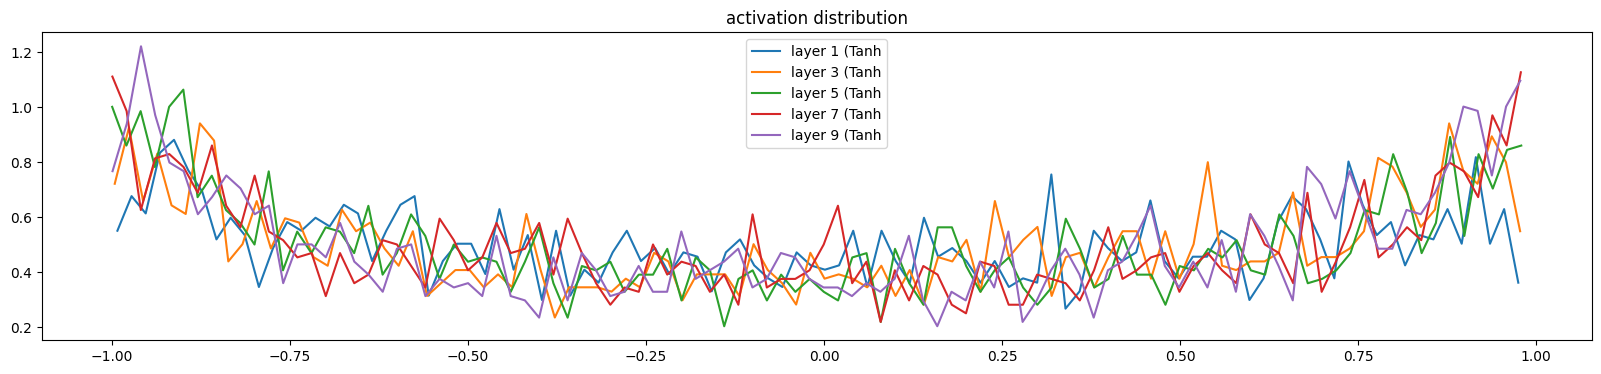

In [86]:
# Tanh activation

plot_activation_distribution(layers)

Total number of parameters in model: 46497


Training: 100%|██████████| 1/1 [00:00<00:00, 75.20it/s, loss=3.3016]

layer 1 (      Tanh): mean -0.01, std 0.61, saturated: 3.41%
layer 3 (      Tanh): mean -0.02, std 0.47, saturated: 0.09%
layer 5 (      Tanh): mean +0.00, std 0.39, saturated: 0.00%
layer 7 (      Tanh): mean +0.01, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.31, saturated: 0.00%


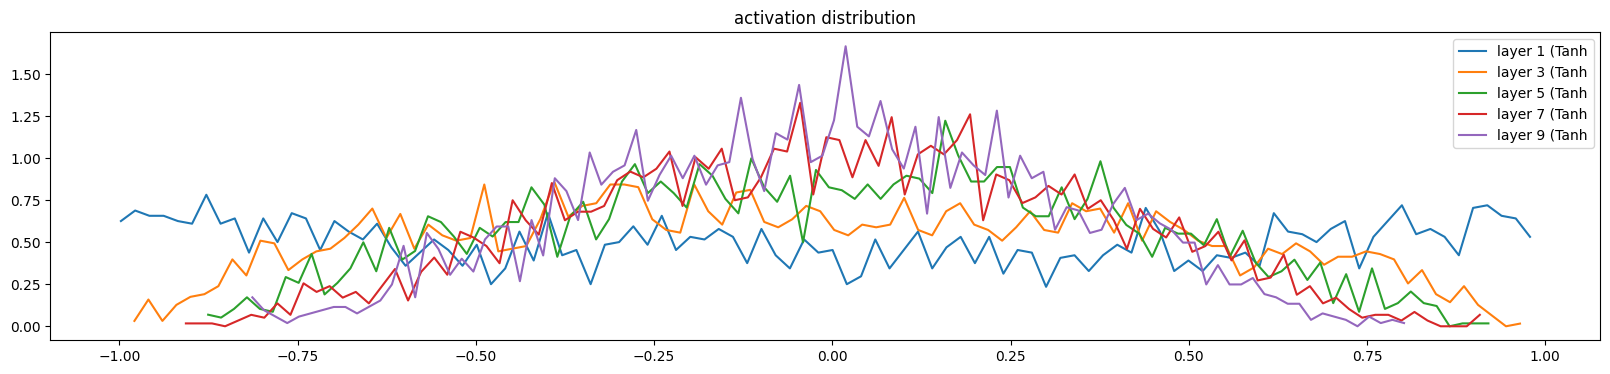

In [87]:
# what happens if we set the tanh gain to 1 instead of 5/3, i.e. something lower?
C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 1.0})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

plot_activation_distribution(layers)

Total number of parameters in model: 46497


Training: 100%|██████████| 1/1 [00:00<00:00, 84.55it/s, loss=3.2898]

layer 1 (      Tanh): mean +0.01, std 0.61, saturated: 2.59%
layer 3 (      Tanh): mean +0.03, std 0.78, saturated: 26.09%
layer 5 (      Tanh): mean +0.03, std 0.83, saturated: 37.25%
layer 7 (      Tanh): mean -0.03, std 0.84, saturated: 39.91%
layer 9 (      Tanh): mean -0.01, std 0.84, saturated: 42.31%


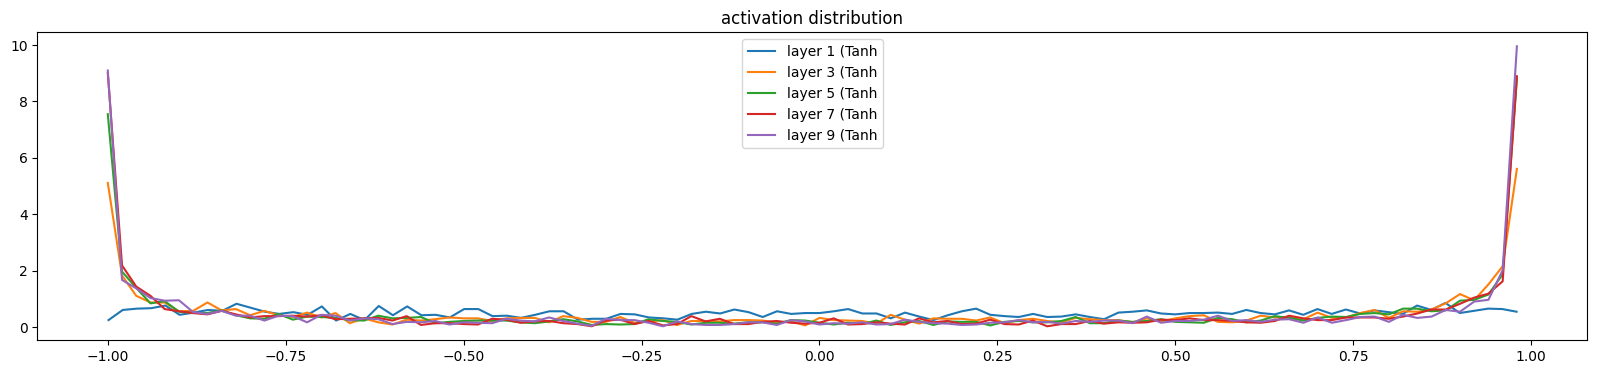

In [88]:
# what happens if we set the tanh gain to 10 instead 3 of 5/3, i.e. something higher?
C, layers, parameters = setup_model(**{**default_params, "tanh_gain": 3.0})
stepi, lossi, loglossi, update_to_data_ratio, layers, parameters = \
    train_model(C, layers, parameters, n_steps=1)

plot_activation_distribution(layers)

We see that without batchnorm, we have to be very careful with our initialization. When we used the suggested `5/3` gain from the Kaiming He paper for tanh, we observe that our layers (regardless of depth) have a std of around `0.65`, with a reasonable number of saturated neurons and hte activations follow a reasonable distributions.

When we `decrease` the gain from `5/3`, we see that the `std` keeps dropping as we go deeper (and we have no saturated neurons). This happens because `tanh` is a squashing fn, it takes its inputs and squahes them to be between ±1. Subsequent tanhs' keep on squashing this further and further. This is undesirable because in this case, when tanh -> 0, the tanh will simply start to act as a passthrough fn and not offer any learnings.

On the flip side, when we increase the gain, we see that the `std` keeps on increasing and we start having more and more staturated neurons. This is because too high of a gain forces the distribution of tanh to act towards its end regions.
